<font color = blue><font size = 6> HDLSTM(Trend) </font></font><br>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time

In [2]:
import torch
import torch.nn as nn
from pytorch_forecasting.metrics import SMAPE
from torch.utils.data import DataLoader,TensorDataset
from torch import FloatTensor
from torch.optim import Adam

/home/sjlee/sj_virtual/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
use_col = ['volumn']
data = pd.read_csv('../../traffic/data/1.csv',usecols=use_col)
data.rename({'volumn':'value'},axis=1,inplace=True)
data['value'] = data['value'] * 8 / 1000000
data

,value
0,22.041608
1,22.048000
2,22.047176
3,22.042408
4,22.049328
...,...
38875,22.316160
38876,22.305744
38877,22.318160
38878,22.310040


In [4]:
import configparser
import os
config = configparser.ConfigParser()
config['online_learning_seq2seq']= {
    'input_size':1,
    'num_layers':1,
    'hidden_size':16,
}
with open('online_learning_seq2seq','w') as f:
    config.write(f)
    
config.read(os.getcwd()+os.sep+'online_learning_seq2seq')

['/hdd_1/sjlee/Paper_Project/SelfMadeModel/online_learning_seq2seq']

In [5]:
class Trend_Encoder(nn.Module):
    def __init__(self,configs):
        super(Trend_Encoder,self).__init__()
        self.input_size = int(configs['online_learning_seq2seq']['input_size'])
        # input의 feature dimension을 넣어주어야 한다
        self.hidden_size = int(configs['online_learning_seq2seq']['hidden_size'])
        # 내부에서 feature dimension을 어떻게 바꿔주고 싶은지 넣어주면 된다
        # 가령 mxn matrix가 입력으로 들어왔을때 hidden size를 h라 한다면 mxh의 크기로 바꾼다
        self.num_layers = int(configs['online_learning_seq2seq']['num_layers'])
        self.lstm = nn.LSTM(input_size=self.input_size,hidden_size = self.hidden_size,
                           num_layers = self.num_layers,batch_first = True)

    
    def forward(self,x):
        lstm_out,hidden = self.lstm(x) 
        #lstm의 output으로 나오는 hidden_state는 마지막 hidden_state값이다
        # hidden에는 튜플형태로 hidden_state와 cell_state가 둘다 포함돼있다
        return lstm_out,hidden

In [6]:
class Trend_Decoder(nn.Module):
    def __init__(self,configs):
        super(Trend_Decoder,self).__init__()
        self.input_size = int(configs['online_learning_seq2seq']['input_size'])
        # input의 feature dimension을 넣어주어야 한다
        self.hidden_size = int(configs['online_learning_seq2seq']['hidden_size'])
        # 내부에서 feature dimension을 어떻게 바꿔주고 싶은지 넣어주면 된다
        # 가령 mxn matrix가 입력으로 들어왔을때 hidden size를 h라 한다면 mxh의 크기로 바꾼다
        self.num_layers = int(configs['online_learning_seq2seq']['num_layers'])
        self.lstm = nn.LSTM(input_size=self.input_size,hidden_size = self.hidden_size,
                           num_layers = self.num_layers,batch_first = True)
        self.linear = nn.Linear(self.hidden_size,self.input_size)
        
    def forward(self,x,encoder_hidden):

        lstm_out,_ = self.lstm(x,encoder_hidden)
        
        output = self.linear(lstm_out)

        return output,_
# 정리하자면 우리가 정답을 알고 있는 시점에서 1시점 전까지의 데이터를 encoder로 넣고
# 알고 있는 마지막시점 정보와 encoder에 넣어서 나온 hidden state를 넣어줌으로써 다음시점을 예측

In [7]:
tup= (1,2)
len(tup)

2

In [8]:
class moving_avg(nn.Module):
    """
    Moving average block to highlight the trend of time series
    """
    def __init__(self, kernel_size, stride):
        super(moving_avg, self).__init__()
        self.kernel_size = kernel_size
        self.avg = nn.AvgPool1d(kernel_size=kernel_size, stride=stride, padding=0)

    def forward(self, x):
        
        x = x.permute(0, 2, 1)
        # padding on the both ends of time series
        front = x[:, 0:1, :].repeat(1, (self.kernel_size - 1) // 2, 1)
        
        end = x[:, -1:, :].repeat(1, (self.kernel_size - 1) // 2, 1)

        x = torch.cat([front, x, end], dim=1)
       
        x = self.avg(x.permute(0,2,1))

        return x

In [9]:
class series_decomp(nn.Module):
    "statsmodels.tsa의 seasonal_decompose와 역할이 똑같다"
    def __init__(self,kernel_size):
        super(series_decomp,self).__init__()
        self.moving_avg = moving_avg(kernel_size,stride = 1)
    
    def forward(self,x):
        moving_mean = self.moving_avg(x) #output은 (batch,sequence_length,input_size)
        res = x - moving_mean 
        # Classical ma중에서 additive model

        return res,moving_mean

In [10]:
class seq2seq(nn.Module):
    def __init__(self,configs):
        super(seq2seq,self).__init__()
        self.device = torch.device('cuda:0')
        self.trend_encoder = Trend_Encoder(configs)
        self.trend_decoder = Trend_Decoder(configs)
        
        self.Linear_Seasonal = nn.Linear(1440,1)
        
        kernel_size = 25
        self.decomposition = series_decomp(kernel_size)
        
    def forward(self,x):
        div_factor = x[:,-1,:].view(-1,1,1)
        x = x-div_factor
        outputs = torch.zeros(x.size(0),1,1) # feature가1개고 target도 1개인 데이터
        x = x.permute(0,2,1)
        seasonal_init,trend_init = self.decomposition(x) # res = seasonality 를 moving_mean은 trend를 의미함
        seasonal_init,trend_init = seasonal_init.to(self.device), trend_init.permute(0,2,1).to(self.device) 

        _,final_trend_hidden = self.trend_encoder(trend_init)
        trend_output,_ = self.trend_decoder(x = trend_init[:,-1,:].view(-1,1,1),encoder_hidden = final_trend_hidden)
        season_output = self.Linear_Seasonal(seasonal_init)
        
        output = (trend_output+season_output)+div_factor
        
        return output,season_output,trend_output

In [11]:
def seq_data(x,sequence_length,pred_len):
    seq_list = []
    target_list = []
    device = torch.device("cuda:0")
    if (type(x)==list)|(type(x)==np.ndarray):
        for i in range(len(x)-sequence_length):
            seq_list.append(x[i:i+sequence_length].values)
            target_list.append(x[i+sequence_length])
    
    if (type(x) == pd.Series)|(type(x) == pd.DataFrame):
        for i in range(len(x)-sequence_length):
            seq_list.append(x.iloc[i:i+sequence_length].values)
            target_list.append(x.iloc[i+sequence_length])

#             if i == 0:
#                  print(x.iloc[i:i+sequence_length].values)
#                  print(y[i+sequence_length:i+sequence_length+pred_len].values)
            #print(x[i+sequence_length:i+sequence_length+pred_len].values.shape)
    else:
        print('error')

    return FloatTensor(seq_list).view(-1,1,sequence_length).to(device),FloatTensor(target_list).unsqueeze(1).view(-1,1,pred_len).to(device)

In [12]:
sequence_length = 1440
pred_len = 1
split= 10080
x_data = pd.DataFrame({'value':data.iloc[:-split].values.reshape(-1)})
x_seq,target = seq_data(x=x_data,sequence_length=sequence_length,pred_len=pred_len)

/tmp/ipykernel_527277/197408478.py:22: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:230.)
  return FloatTensor(seq_list).view(-1,1,sequence_length).to(device),FloatTensor(target_list).unsqueeze(1).view(-1,1,pred_len).to(device)


In [13]:
x_seq

tensor([[[22.0416, 22.0480, 22.0472,  ..., 22.0650, 22.0639, 22.0667]],

        [[22.0480, 22.0472, 22.0424,  ..., 22.0639, 22.0667, 22.0614]],

        [[22.0472, 22.0424, 22.0493,  ..., 22.0667, 22.0614, 22.0653]],

        ...,

        [[22.3283, 22.3387, 22.3413,  ..., 22.4329, 22.4284, 22.4437]],

        [[22.3387, 22.3413, 22.3290,  ..., 22.4284, 22.4437, 22.4421]],

        [[22.3413, 22.3290, 22.3190,  ..., 22.4437, 22.4421, 22.4284]]],
       device='cuda:0')

In [14]:
target

tensor([[[22.0614]],

        [[22.0653]],

        [[22.0655]],

        ...,

        [[22.4421]],

        [[22.4284]],

        [[22.4296]]], device='cuda:0')

In [15]:
import torch.optim as optim

device = torch.device('cuda:0')
batch_size = 32
num_epochs = 100
train_dataset = TensorDataset(x_seq,target)
training = DataLoader(train_dataset,batch_size=batch_size)
model = seq2seq(config).to(device)
optimizer = Adam(model.parameters(),1e-3)
criterion = SMAPE()
scheduler = optim.lr_scheduler.LambdaLR(optimizer=optimizer,
                                        lr_lambda=lambda epoch: 0.95 ** epoch,verbose = True)
                                       # epoch마다 learning rate에 곱해지는 값이 제곱수로 늘어남

Adjusting learning rate of group 0 to 1.0000e-03.


In [16]:
torch.manual_seed(42)

In [17]:
x_seq

tensor([[[22.0416, 22.0480, 22.0472,  ..., 22.0650, 22.0639, 22.0667]],

        [[22.0480, 22.0472, 22.0424,  ..., 22.0639, 22.0667, 22.0614]],

        [[22.0472, 22.0424, 22.0493,  ..., 22.0667, 22.0614, 22.0653]],

        ...,

        [[22.3283, 22.3387, 22.3413,  ..., 22.4329, 22.4284, 22.4437]],

        [[22.3387, 22.3413, 22.3290,  ..., 22.4284, 22.4437, 22.4421]],

        [[22.3413, 22.3290, 22.3190,  ..., 22.4437, 22.4421, 22.4284]]],
       device='cuda:0')

In [18]:
out_list = []
loss_list = []
ss_list = []
tr_list = []
n = len(training)
for i in range(num_epochs):
    running_loss = 0.0
    for seq,tg in training:
        
        seq = seq.permute(0,2,1)
#         print(seq)
        out,ss,tr = model(seq)
#         print(out)
        loss = criterion(out,tg)
        
        optimizer.zero_grad()
        
        loss.backward()
        
        optimizer.step() # optimizer 최적화
        
        ss_list.append(ss)
        tr_list.append(tr)
        
        running_loss = running_loss + loss.item()        
    scheduler.step() #schedular update 
    loss_list.append(running_loss/n)
    print('smape',running_loss/n*100,'%')                

Adjusting learning rate of group 0 to 9.5000e-04.
smape 0.12596205905405258 %
Adjusting learning rate of group 0 to 9.0250e-04.
smape 0.10355976703801403 %
Adjusting learning rate of group 0 to 8.5737e-04.
smape 0.09739531815284863 %
Adjusting learning rate of group 0 to 8.1451e-04.
smape 0.08689362147097252 %
Adjusting learning rate of group 0 to 7.7378e-04.
smape 0.07646787565641312 %
Adjusting learning rate of group 0 to 7.3509e-04.
smape 0.07399149186982724 %
Adjusting learning rate of group 0 to 6.9834e-04.
smape 0.0702294974491866 %
Adjusting learning rate of group 0 to 6.6342e-04.
smape 0.07057160813407701 %
Adjusting learning rate of group 0 to 6.3025e-04.
smape 0.06540858547771022 %
Adjusting learning rate of group 0 to 5.9874e-04.
smape 0.06707558875742821 %
Adjusting learning rate of group 0 to 5.6880e-04.
smape 0.06367571316135241 %
Adjusting learning rate of group 0 to 5.4036e-04.
smape 0.06602466219085765 %
Adjusting learning rate of group 0 to 5.1334e-04.
smape 0.0624403

In [19]:
device = torch.device('cuda:0')
X = data.iloc[:-split]
target = data.iloc[-split:]
pred_list = []
time_list = []

for idx in range(split):
    running_loss = 0.0
    start = time.time()
    model.train()
    for epochs in range(num_epochs):
        if idx == 0: 
            new_train = torch.FloatTensor(
                [X.iloc[-sequence_length-1:-1].values] # 현재 알고 있는 마지막 정답에서 하나 이전 값 까지가 Training Data
            ).view(1,-1,1).to(device)

            tg = FloatTensor(X.iloc[-1]).view(1,1,1).to(device)
           
        elif idx == 1:
            new_train = torch.FloatTensor(
                [X.iloc[-sequence_length-1+idx:].values] # 현재 알고 있는 마지막 정답에서 하나 이전 값 까지가 Training Data
            ).view(1,-1,1).to(device)
            
            tg = FloatTensor(target.iloc[0]).view(1,1,1).to(device)
        else:        
            if idx <= sequence_length:# idx가 1보다는 크고 sequence_length보단 작거나 같은경우
                new_train = torch.FloatTensor(
                    [pd.concat([X.iloc[-sequence_length+idx-1:],target.iloc[0:idx-1]],axis=0,ignore_index=True).values]
                    ).view(1,-1,1).to(device)

                tg = FloatTensor(target.iloc[idx-1]).view(1,1,1).to(device)

            elif idx > sequence_length:
                new_train = torch.FloatTensor(
                    [target.iloc[idx-sequence_length-1:idx-1].values]
                    ).view(1,-1,1).to(device)
                
                tg = FloatTensor(target.iloc[idx-1]).view(1,1,1).to(device)

        out,_,_ = model(new_train) # 예측완료

        loss = criterion(out,tg)# 예측값과 타겟값의 비교

        optimizer.zero_grad()
        
        loss.backward()
        
        optimizer.step() # optimizer 최적화
            
        running_loss = running_loss + loss.item()
    
    real_input = torch.cat([new_train[:,1:,:],tg],dim=1)
    
    with torch.no_grad(): #model.eval()과 train()은 레이어에만 영향을 준다 with문이 끝나면 자동 종료
        model.eval()
        real_out,_,_ = model(real_input)
    model.train()        
    print('SMAPE',(running_loss/100)*100,'%')
    end = time.time()
    pred_list.append(real_out.cpu().view(1).item())
    time_list.append(end-start)


SMAPE 0.06483365425810916 %
SMAPE 0.0972852450213395 %
SMAPE 0.16723862232174724 %
SMAPE 0.0926326842745766 %
SMAPE 0.023803835076904534 %
SMAPE 0.33054687292315066 %
SMAPE 0.017454072935635168 %
SMAPE 0.08646048948867247 %
SMAPE 0.22451492445543408 %
SMAPE 0.0097796692792258 %
SMAPE 0.10632952366722748 %
SMAPE 0.09567526658065617 %
SMAPE 0.22618943266570568 %
SMAPE 0.07555154548026621 %
SMAPE 0.1359964848961681 %
SMAPE 0.0458266633504536 %
SMAPE 0.02559224529568382 %
SMAPE 0.1901268473593518 %
SMAPE 0.022257656898602818 %
SMAPE 0.024895409794794432 %
SMAPE 0.03266178144986043 %
SMAPE 0.12504587997682393 %
SMAPE 0.26601137686520815 %
SMAPE 0.2229936413932592 %
SMAPE 0.05163351423107087 %
SMAPE 0.09144982841098681 %
SMAPE 0.1678113549714908 %
SMAPE 0.10806817107368262 %
SMAPE 0.43172902148216963 %
SMAPE 0.0008051818630434582 %
SMAPE 0.27730605797842145 %
SMAPE 0.2145580591168255 %
SMAPE 0.0015924095508381695 %
SMAPE 0.12073880532989277 %
SMAPE 0.12458656006492674 %
SMAPE 0.1323035364039

SMAPE 0.040049687755526975 %
SMAPE 0.03567882797506172 %
SMAPE 0.018488651926077182 %
SMAPE 0.007037360112654767 %
SMAPE 0.0490746452123858 %
SMAPE 0.02369235976584605 %
SMAPE 0.001129713758359685 %
SMAPE 0.0027517261864673515 %
SMAPE 0.03748063054808881 %
SMAPE 0.010432117663853546 %
SMAPE 0.007592278926502161 %
SMAPE 0.004905436303332067 %
SMAPE 0.004787334093137474 %
SMAPE 0.06025052134646103 %
SMAPE 0.00191212053067602 %
SMAPE 0.08001010812586173 %
SMAPE 0.05913935994612985 %
SMAPE 0.016946733970883088 %
SMAPE 0.04072472781990655 %
SMAPE 0.035435837155091576 %
SMAPE 0.03932205955788959 %
SMAPE 0.01893775863220526 %
SMAPE 0.10604272148339076 %
SMAPE 0.015157456143924719 %
SMAPE 0.001924029952064643 %
SMAPE 0.2526773123536259 %
SMAPE 0.0002996759366880042 %
SMAPE 0.12746792170219123 %
SMAPE 0.0789669516379945 %
SMAPE 0.08254941611085087 %
SMAPE 0.0789451845921576 %
SMAPE 0.01079996910493719 %
SMAPE 0.004115230011379367 %
SMAPE 0.06189898672164418 %
SMAPE 0.0876170881674625 %
SMAPE 0.

SMAPE 0.005186263256078405 %
SMAPE 0.03637069898832124 %
SMAPE 0.04644983043544926 %
SMAPE 0.016480133934805963 %
SMAPE 0.10468145023332909 %
SMAPE 0.19803850015159696 %
SMAPE 0.07261638808995485 %
SMAPE 0.018256295344627915 %
SMAPE 0.0372804253565846 %
SMAPE 0.03410389488271903 %
SMAPE 0.0278324224127573 %
SMAPE 0.00183102916378175 %
SMAPE 0.005249929926549157 %
SMAPE 0.011513748345151953 %
SMAPE 0.001833276604415346 %
SMAPE 0.05913854349637404 %
SMAPE 0.014037351652802952 %
SMAPE 0.030756168744119353 %
SMAPE 0.04269900862709619 %
SMAPE 0.03651725439704023 %
SMAPE 0.042005938972579315 %
SMAPE 0.02603831511805765 %
SMAPE 0.05602223268942907 %
SMAPE 0.11479925271123649 %
SMAPE 0.08035862661199644 %
SMAPE 0.062144810915924616 %
SMAPE 0.003945035379686601 %
SMAPE 0.012515653219338674 %
SMAPE 0.055214869207702584 %
SMAPE 0.04383458757365588 %
SMAPE 0.0011966853054730109 %
SMAPE 0.07786724640754983 %
SMAPE 0.018118079165304835 %
SMAPE 0.029854760687157977 %
SMAPE 0.0021584789326354326 %
SMA

SMAPE 0.06431140485801734 %
SMAPE 0.030719140901055656 %
SMAPE 0.009514075855591386 %
SMAPE 0.02150399745460163 %
SMAPE 0.0023793832050813535 %
SMAPE 0.029398681792372375 %
SMAPE 0.018368827656559006 %
SMAPE 0.021956399163173046 %
SMAPE 0.001969686062111009 %
SMAPE 0.10719229793176054 %
SMAPE 0.07203300710534677 %
SMAPE 0.006584562103938652 %
SMAPE 0.07954660529503599 %
SMAPE 0.00927766712806033 %
SMAPE 0.06340006660320796 %
SMAPE 0.02229715246357955 %
SMAPE 0.001149126846499371 %
SMAPE 0.07239682925865054 %
SMAPE 0.007137971015524159 %
SMAPE 0.003469803765582924 %
SMAPE 0.0006185361235964137 %
SMAPE 0.07010425592307001 %
SMAPE 0.0773756576818414 %
SMAPE 0.03526684254757129 %
SMAPE 0.03795582188467961 %
SMAPE 0.05675577622605488 %
SMAPE 0.04279116785619408 %
SMAPE 0.008003088249878942 %
SMAPE 0.032222152382018976 %
SMAPE 0.024947242673079018 %
SMAPE 0.08469551906455308 %
SMAPE 0.13089185138233006 %
SMAPE 0.0025463896214006354 %
SMAPE 0.11730281729251145 %
SMAPE 0.09159302938496694 %
SM

SMAPE 0.023891657901913277 %
SMAPE 0.028075774171156812 %
SMAPE 0.007740592045848871 %
SMAPE 0.0074867481122566915 %
SMAPE 0.10148251755163075 %
SMAPE 0.004879235764832401 %
SMAPE 0.07496279419865459 %
SMAPE 0.010944187787060855 %
SMAPE 0.06845568041899242 %
SMAPE 0.040496043060556985 %
SMAPE 0.06475674494868144 %
SMAPE 0.06480686413124204 %
SMAPE 0.05846851514070294 %
SMAPE 0.005457609738655833 %
SMAPE 0.1386990211904049 %
SMAPE 0.012706266214365769 %
SMAPE 0.01279688981330196 %
SMAPE 0.09152141719823703 %
SMAPE 0.13120850722771138 %
SMAPE 0.07458186423173174 %
SMAPE 0.01903472192765321 %
SMAPE 0.04953867255244404 %
SMAPE 0.049816263315733515 %
SMAPE 0.008528719563116738 %
SMAPE 0.0534229307086207 %
SMAPE 0.002342923977877831 %
SMAPE 0.056892628548666835 %
SMAPE 0.04858455594512634 %
SMAPE 0.003497493445195232 %
SMAPE 0.018073365215400372 %
SMAPE 0.07254412258043885 %
SMAPE 0.0009354492683399939 %
SMAPE 0.011248338416805836 %
SMAPE 0.009020218078916287 %
SMAPE 0.007454830046725647 %
S

SMAPE 0.03141277977556456 %
SMAPE 0.016200919096604594 %
SMAPE 0.07415769662475213 %
SMAPE 0.0304304772434989 %
SMAPE 0.06899402395356447 %
SMAPE 0.024293556583870668 %
SMAPE 0.0013143075372070712 %
SMAPE 0.046040322675253265 %
SMAPE 0.015887724430115213 %
SMAPE 0.04835092509165406 %
SMAPE 0.06739708929671906 %
SMAPE 0.06771935036522336 %
SMAPE 0.057211681065382436 %
SMAPE 0.0010614891216675915 %
SMAPE 0.07942116685444489 %
SMAPE 0.09279612946556881 %
SMAPE 0.08631412085378543 %
SMAPE 0.03527579137880821 %
SMAPE 0.024669245980476266 %
SMAPE 0.07368193933507428 %
SMAPE 0.13961953937541693 %
SMAPE 0.0015345626830765013 %
SMAPE 0.006626702567260168 %
SMAPE 0.00019498847151311338 %
SMAPE 0.013703274983072332 %
SMAPE 0.045078295515850186 %
SMAPE 0.02766426451125881 %
SMAPE 0.008542382562836792 %
SMAPE 0.003511819163577456 %
SMAPE 0.040280059081851505 %
SMAPE 0.007419849789670251 %
SMAPE 0.003846399659323652 %
SMAPE 0.006386228129144911 %
SMAPE 0.0004309500530226274 %
SMAPE 0.008616479301650

SMAPE 0.08359800430480391 %
SMAPE 0.013391592421555742 %
SMAPE 0.03856229876691941 %
SMAPE 0.05402072073775343 %
SMAPE 0.10203280311543496 %
SMAPE 0.07642690878128633 %
SMAPE 0.0048587613061030765 %
SMAPE 5.2171358973396316e-05 %
SMAPE 0.0001429068142755341 %
SMAPE 0.1320939534343779 %
SMAPE 0.040315884456504136 %
SMAPE 0.043980786111205816 %
SMAPE 0.09500774519983679 %
SMAPE 0.028141208524175454 %
SMAPE 0.00010017613655577408 %
SMAPE 0.01025742710660893 %
SMAPE 0.00280672901639889 %
SMAPE 0.016358958190899386 %
SMAPE 0.04256581024674233 %
SMAPE 0.033203088940354064 %
SMAPE 0.0545269881549757 %
SMAPE 0.0007118445384577399 %
SMAPE 0.13455233036074787 %
SMAPE 0.011324972972971636 %
SMAPE 0.0003815627220404849 %
SMAPE 0.015144160749741786 %
SMAPE 0.02261415408429457 %
SMAPE 0.001279041190748842 %
SMAPE 0.011176230314191571 %
SMAPE 0.017749860084734337 %
SMAPE 0.08033189986599609 %
SMAPE 0.05462027064641006 %
SMAPE 0.03381592791993171 %
SMAPE 0.02201818755020213 %
SMAPE 0.01042927550747663

SMAPE 0.00040800457607303997 %
SMAPE 0.05967085444717668 %
SMAPE 0.03924975011614151 %
SMAPE 0.00026260298420055506 %
SMAPE 0.05257194399018772 %
SMAPE 0.009690804026746491 %
SMAPE 0.01356449016100214 %
SMAPE 0.10883240978000686 %
SMAPE 0.028794396559533197 %
SMAPE 0.008863965322063905 %
SMAPE 0.0061795632365431175 %
SMAPE 0.09914799564285204 %
SMAPE 0.044427290005842224 %
SMAPE 0.0029340088848073265 %
SMAPE 0.03353740298189223 %
SMAPE 0.09225227223942056 %
SMAPE 0.03246243216563016 %
SMAPE 0.11153775005368516 %
SMAPE 0.036204072152031586 %
SMAPE 0.00895544251821434 %
SMAPE 0.00011555496283222057 %
SMAPE 0.01911292897148087 %
SMAPE 0.02181608738283103 %
SMAPE 0.00961850403434994 %
SMAPE 0.08716798946261406 %
SMAPE 0.0006976215219935966 %
SMAPE 0.07641592313302681 %
SMAPE 0.04796238857670687 %
SMAPE 0.08691070467466488 %
SMAPE 0.0003318439044335264 %
SMAPE 0.07489568495657295 %
SMAPE 0.06592130134231411 %
SMAPE 0.05156567436642945 %
SMAPE 0.061838029709178954 %
SMAPE 0.03142107513849623

SMAPE 0.17629464471247047 %
SMAPE 0.00913709273742569 %
SMAPE 0.004309291927647507 %
SMAPE 0.014125505847118802 %
SMAPE 0.004816794783884859 %
SMAPE 0.039517951488960534 %
SMAPE 0.006620180499396611 %
SMAPE 0.052999869658378884 %
SMAPE 0.09053605439839885 %
SMAPE 0.15347635583020747 %
SMAPE 0.03408472011506092 %
SMAPE 0.07598789327312261 %
SMAPE 0.028015141549985856 %
SMAPE 0.14414818456862122 %
SMAPE 0.13165061105974019 %
SMAPE 0.049457793444162235 %
SMAPE 0.001744648674637972 %
SMAPE 0.00304009443807729 %
SMAPE 0.15058222389779985 %
SMAPE 0.035882784068235196 %
SMAPE 0.0195716891749953 %
SMAPE 0.09559978236211464 %
SMAPE 0.01853821276409917 %
SMAPE 0.026418820547405627 %
SMAPE 0.14171449793502688 %
SMAPE 0.0336003742122557 %
SMAPE 0.06176774881896563 %
SMAPE 0.1628842350328341 %
SMAPE 0.1377441774820909 %
SMAPE 0.0675866782257799 %
SMAPE 0.017467231117052506 %
SMAPE 0.23155271308496597 %
SMAPE 0.03939084782905411 %
SMAPE 0.011135088021262618 %
SMAPE 0.024031444470892893 %
SMAPE 0.183

SMAPE 0.03134392981155543 %
SMAPE 0.006881815873157394 %
SMAPE 0.007189880050070485 %
SMAPE 0.03436456595954951 %
SMAPE 0.09975146572105587 %
SMAPE 0.18209236057009548 %
SMAPE 0.15738114633131772 %
SMAPE 0.10599636129336432 %
SMAPE 0.15047551528550684 %
SMAPE 0.20507859881035984 %
SMAPE 0.002132815072755534 %
SMAPE 0.09039843548089266 %
SMAPE 0.06400553972343914 %
SMAPE 0.02202958614725503 %
SMAPE 0.03287038768758066 %
SMAPE 0.07456209138035774 %
SMAPE 0.020016124647554534 %
SMAPE 0.04848396920715459 %
SMAPE 0.0013988829357671761 %
SMAPE 0.10827462846646085 %
SMAPE 0.0023846153812741022 %
SMAPE 0.0031669423527205254 %
SMAPE 3.523387432835534e-05 %
SMAPE 0.08506512368330732 %
SMAPE 0.13685953058302402 %
SMAPE 0.0056487766045094645 %
SMAPE 0.00848297485498506 %
SMAPE 0.13203146471641958 %
SMAPE 0.007883821606043284 %
SMAPE 0.02351995751087088 %
SMAPE 0.0007652355826834878 %
SMAPE 0.12991090572904795 %
SMAPE 0.04237002899753861 %
SMAPE 0.09401844011154026 %
SMAPE 0.06402339399210177 %
SMA

SMAPE 1.1268381224945188 %
SMAPE 0.2673325113719329 %
SMAPE 0.7946072686463594 %
SMAPE 0.24851815844886008 %
SMAPE 1.6731281038373709 %
SMAPE 0.9091105461120605 %
SMAPE 0.23408570734318343 %
SMAPE 0.825371515005827 %
SMAPE 0.30395559361204505 %
SMAPE 1.0543561428785324 %
SMAPE 0.17130151053424925 %
SMAPE 0.12129363275016657 %
SMAPE 0.007778295528282797 %
SMAPE 0.25982862734235823 %
SMAPE 0.28327131422702223 %
SMAPE 0.023977557730972876 %
SMAPE 1.3156634718179703 %
SMAPE 1.8512987960129976 %
SMAPE 2.4422853644937277 %
SMAPE 2.757992124184966 %
SMAPE 1.463812304660678 %
SMAPE 0.013106506971837462 %
SMAPE 0.7527790777385235 %
SMAPE 0.14296580193331465 %
SMAPE 1.3018756918609142 %
SMAPE 1.5611676620319486 %
SMAPE 1.692038994282484 %
SMAPE 0.6476418045349419 %
SMAPE 0.4102377877570689 %
SMAPE 0.08384938813924236 %
SMAPE 0.13951372663723305 %
SMAPE 0.1625133769121021 %
SMAPE 0.31439391104504466 %
SMAPE 0.6190862860530615 %
SMAPE 0.29533998924307525 %
SMAPE 0.5993666048161685 %
SMAPE 0.139788

SMAPE 2.0572155918926 %
SMAPE 2.0020448081195354 %
SMAPE 1.7825835030525923 %
SMAPE 0.824651915114373 %
SMAPE 0.7006556382402778 %
SMAPE 2.0234112981706858 %
SMAPE 0.46815190743654966 %
SMAPE 0.1476363677647896 %
SMAPE 0.6434257668443024 %
SMAPE 0.5005944650620222 %
SMAPE 1.7584213074296713 %
SMAPE 1.9905959200114014 %
SMAPE 0.6218193778768182 %
SMAPE 0.20863519329577684 %
SMAPE 0.0326458307079065 %
SMAPE 0.39185974816791713 %
SMAPE 0.34660672303289175 %
SMAPE 0.26060528634116054 %
SMAPE 1.021259161643684 %
SMAPE 0.21720824181102213 %
SMAPE 0.6074415408074856 %
SMAPE 0.024411819204317453 %
SMAPE 0.9073530258610845 %
SMAPE 0.3436756955925375 %
SMAPE 0.8098453609272838 %
SMAPE 0.006921168021996493 %
SMAPE 0.6120179514400661 %
SMAPE 0.2697786202188581 %
SMAPE 0.1264581319410354 %
SMAPE 0.050408161022915 %
SMAPE 0.15676158375572413 %
SMAPE 0.7482975204475224 %
SMAPE 1.579992884770036 %
SMAPE 1.0890184491872787 %
SMAPE 0.5672340863384306 %
SMAPE 0.5598272192291915 %
SMAPE 2.6246209163218737

SMAPE 0.6942072962410748 %
SMAPE 0.6283199614845216 %
SMAPE 0.7176703461445868 %
SMAPE 0.4113070424646139 %
SMAPE 0.5889193951152265 %
SMAPE 0.21515349589753896 %
SMAPE 0.4714619859587401 %
SMAPE 0.6454033660702407 %
SMAPE 0.5214510192163289 %
SMAPE 0.5274796271696687 %
SMAPE 1.9095473866909745 %
SMAPE 1.3898410769179463 %
SMAPE 0.9898211741819978 %
SMAPE 0.44784560543484986 %
SMAPE 0.9091501422226429 %
SMAPE 0.3231786957476288 %
SMAPE 0.5594376609660685 %
SMAPE 1.4238973027095199 %
SMAPE 1.4426936991512775 %
SMAPE 1.3098185351118445 %
SMAPE 0.6753768874332309 %
SMAPE 0.18221815070137382 %
SMAPE 0.42171303648501635 %
SMAPE 0.5245422613807023 %
SMAPE 0.19168600183911622 %
SMAPE 1.1445230841636658 %
SMAPE 0.678623232524842 %
SMAPE 0.2739363081054762 %
SMAPE 0.5571590298786759 %
SMAPE 1.222502856515348 %
SMAPE 0.27045319497119635 %
SMAPE 0.5922712609171867 %
SMAPE 1.3015363793820143 %
SMAPE 2.427531536668539 %
SMAPE 2.958259977400303 %
SMAPE 2.3915745839476585 %
SMAPE 0.8311379882507026 %

SMAPE 0.8620032537728549 %
SMAPE 0.3798430336173624 %
SMAPE 0.4863139609806239 %
SMAPE 0.8758356757462026 %
SMAPE 1.566882117651403 %
SMAPE 1.0314652808010578 %
SMAPE 0.6855798605829477 %
SMAPE 2.1627823188900948 %
SMAPE 1.1796932816505432 %
SMAPE 0.8065637876279652 %
SMAPE 0.07858505594958842 %
SMAPE 1.8613211400806902 %
SMAPE 2.1659618094563484 %
SMAPE 0.4407904574181884 %
SMAPE 0.35091593815013766 %
SMAPE 0.49226441048085695 %
SMAPE 0.04771496635510175 %
SMAPE 0.49360470846295357 %
SMAPE 1.002478244714439 %
SMAPE 1.482989969663322 %
SMAPE 0.9461540887132287 %
SMAPE 0.6454300917685032 %
SMAPE 0.35760945454239845 %
SMAPE 0.28604572638869286 %
SMAPE 1.235307645983994 %
SMAPE 0.41481218580156565 %
SMAPE 0.5293973856605589 %
SMAPE 0.42854438675567513 %
SMAPE 0.35630045644938946 %
SMAPE 0.6801939276047051 %
SMAPE 0.7301299702376127 %
SMAPE 1.1085106702521443 %
SMAPE 0.025258910687000483 %
SMAPE 1.0146547090262175 %
SMAPE 1.3624721858650446 %
SMAPE 0.7104216376319528 %
SMAPE 0.017205909463

SMAPE 2.5138991493731737 %
SMAPE 3.5950241684913635 %
SMAPE 2.5886788573116064 %
SMAPE 0.5953087015077472 %
SMAPE 1.3653059424832463 %
SMAPE 2.973929660394788 %
SMAPE 2.9170714411884546 %
SMAPE 2.1371296495199203 %
SMAPE 2.0476097110658884 %
SMAPE 0.3608710765838623 %
SMAPE 0.6650947732850909 %
SMAPE 1.6795690525323153 %
SMAPE 1.9859970062971115 %
SMAPE 2.141702340915799 %
SMAPE 2.3239611126482487 %
SMAPE 0.018285521064456134 %
SMAPE 0.4598936107940972 %
SMAPE 2.4452232625335455 %
SMAPE 1.3783007394522429 %
SMAPE 0.002233064461933054 %
SMAPE 0.271810197038576 %
SMAPE 1.8945177141577003 %
SMAPE 2.0290427953004837 %
SMAPE 0.008810215120547582 %
SMAPE 0.011208031006972874 %
SMAPE 0.667282014619559 %
SMAPE 1.1379313105717301 %
SMAPE 0.06360259356597453 %
SMAPE 1.0035931030288339 %
SMAPE 3.326377131044864 %
SMAPE 2.7480185758322477 %
SMAPE 2.537589577957988 %
SMAPE 1.9935576114803553 %
SMAPE 1.0641640303656459 %
SMAPE 3.237591065466404 %
SMAPE 3.7454771324992175 %
SMAPE 1.3694417010992765 %

SMAPE 0.17266795493196696 %
SMAPE 0.3001878729555756 %
SMAPE 0.7229353357106447 %
SMAPE 1.5564927272498608 %
SMAPE 1.616887523792684 %
SMAPE 1.6829084269702435 %
SMAPE 1.0373965911567211 %
SMAPE 0.15888076892588288 %
SMAPE 0.005585769966813814 %
SMAPE 0.5325614297762513 %
SMAPE 1.5433141253888607 %
SMAPE 1.3680959744378924 %
SMAPE 0.9986518351361156 %
SMAPE 0.6300200414843857 %
SMAPE 0.17482664698036388 %
SMAPE 0.00047765199654747903 %
SMAPE 0.3130363665986806 %
SMAPE 0.4484344464726746 %
SMAPE 0.14822566567454487 %
SMAPE 0.9073006445541978 %
SMAPE 1.9436319544911385 %
SMAPE 1.8851763885468245 %
SMAPE 1.6377931097522378 %
SMAPE 0.7225205306895077 %
SMAPE 0.27128872473258525 %
SMAPE 0.7567618424072862 %
SMAPE 0.9071575393900275 %
SMAPE 0.10069992626085879 %
SMAPE 0.48722433252260083 %
SMAPE 1.7385150678455827 %
SMAPE 1.494309427216649 %
SMAPE 0.2694881826173514 %
SMAPE 0.409292847616598 %
SMAPE 0.6329526635818183 %
SMAPE 0.8538379799574614 %
SMAPE 1.303109310567379 %
SMAPE 0.92482020333

SMAPE 1.218680010177195 %
SMAPE 2.15627876855433 %
SMAPE 1.5975905340164898 %
SMAPE 2.55732505582273 %
SMAPE 0.9536212310194969 %
SMAPE 0.3655742334667593 %
SMAPE 0.5797205991111696 %
SMAPE 0.2061357091879472 %
SMAPE 1.4190407637506723 %
SMAPE 0.5784430149942636 %
SMAPE 0.5841060769744217 %
SMAPE 0.9394624922424554 %
SMAPE 0.5007404654752463 %
SMAPE 0.5669636954553425 %
SMAPE 0.009619271491374093 %
SMAPE 0.19888512330362573 %
SMAPE 0.5179424409288913 %
SMAPE 0.44551530038006604 %
SMAPE 0.3315196083858609 %
SMAPE 0.7583459257148206 %
SMAPE 0.8600695054046809 %
SMAPE 0.487135260598734 %
SMAPE 0.1467896864778595 %
SMAPE 0.27115432044956833 %
SMAPE 0.7208838299848139 %
SMAPE 1.157612506300211 %
SMAPE 1.2933295611292124 %
SMAPE 1.177981000393629 %
SMAPE 1.2827087454497814 %
SMAPE 0.20419509842758998 %
SMAPE 0.10384689630973298 %
SMAPE 0.22981172165600583 %
SMAPE 0.6850672508589923 %
SMAPE 0.6164677594788373 %
SMAPE 0.3718361142091453 %
SMAPE 0.48496332205832 %
SMAPE 1.7010933710262177 %
SMA

SMAPE 0.11850626475415993 %
SMAPE 0.6426419755443931 %
SMAPE 1.1949094207957387 %
SMAPE 1.2476347349584103 %
SMAPE 0.440609676996246 %
SMAPE 0.1341443252076715 %
SMAPE 0.745208456646651 %
SMAPE 0.7815432706847788 %
SMAPE 0.9797979537397623 %
SMAPE 1.7311477679759264 %
SMAPE 1.898588681593537 %
SMAPE 2.6055776197463274 %
SMAPE 2.86939144320786 %
SMAPE 2.080950263887644 %
SMAPE 1.190292821265757 %
SMAPE 1.0312970131635666 %
SMAPE 0.1409204363999379 %
SMAPE 0.5589020680636168 %
SMAPE 1.582601840607822 %
SMAPE 2.85602018982172 %
SMAPE 2.5256745759397745 %
SMAPE 2.2563984375447035 %
SMAPE 2.315242415294051 %
SMAPE 1.9349722135812046 %
SMAPE 0.8851492810063064 %
SMAPE 0.21505834528943524 %
SMAPE 0.2369387485086918 %
SMAPE 0.13328601551074826 %
SMAPE 0.5864288588054478 %
SMAPE 0.7568074436858296 %
SMAPE 0.9395212782546878 %
SMAPE 1.4993873601779342 %
SMAPE 1.7159242648631334 %
SMAPE 2.2216510474681854 %
SMAPE 1.6551297679543493 %
SMAPE 0.6113769575022161 %
SMAPE 1.2965376963838935 %
SMAPE 0.7

SMAPE 0.418788192095235 %
SMAPE 1.2380464635789394 %
SMAPE 0.2941399523988366 %
SMAPE 0.8356103212572635 %
SMAPE 1.1416282458230853 %
SMAPE 1.353996543213725 %
SMAPE 2.196235839277506 %
SMAPE 1.8313085883855817 %
SMAPE 0.8631539214402437 %
SMAPE 0.6836162600666285 %
SMAPE 0.37631033221259713 %
SMAPE 0.1853904926974792 %
SMAPE 0.4116836618632078 %
SMAPE 1.3624402303248644 %
SMAPE 2.2288847528398037 %
SMAPE 2.5080622415989637 %
SMAPE 2.3758459631353617 %
SMAPE 2.7487518414855003 %
SMAPE 1.8665549028664827 %
SMAPE 0.4672552153933794 %
SMAPE 1.0732033848762512 %
SMAPE 0.938878680113703 %
SMAPE 0.36175353708676994 %
SMAPE 0.03756888939372516 %
SMAPE 0.22163909382652494 %
SMAPE 0.3089322756277397 %
SMAPE 0.5868891826830804 %
SMAPE 0.08117644789376754 %
SMAPE 0.39344511716626585 %
SMAPE 0.061150940103857465 %
SMAPE 0.6765411016531289 %
SMAPE 1.5633093975484371 %
SMAPE 2.5582172870635986 %
SMAPE 2.6537373438477516 %
SMAPE 2.8400282338261604 %
SMAPE 2.3821998331695795 %
SMAPE 0.2615347715327516

SMAPE 2.9745996296405792 %
SMAPE 2.408367447555065 %
SMAPE 0.7398734064772725 %
SMAPE 1.4038575515151024 %
SMAPE 2.293688677251339 %
SMAPE 4.2651208229362965 %
SMAPE 5.185716189444065 %
SMAPE 5.033441260457039 %
SMAPE 4.934935566037893 %
SMAPE 5.213322296738625 %
SMAPE 3.6292034909129143 %
SMAPE 2.249733528122306 %
SMAPE 0.7745510581880808 %
SMAPE 0.6829917286522686 %
SMAPE 1.8165605962276459 %
SMAPE 3.6679520905017853 %
SMAPE 3.123491957783699 %
SMAPE 2.8886709939688444 %
SMAPE 2.691062916070223 %
SMAPE 1.6971027292311192 %
SMAPE 1.7868796121329067 %
SMAPE 1.4612097404897213 %
SMAPE 1.0152203058823943 %
SMAPE 2.7683428693562746 %
SMAPE 3.7140255756676197 %
SMAPE 3.3857569247484203 %
SMAPE 2.1193197555840015 %
SMAPE 0.061621635368624084 %
SMAPE 0.3898327839560807 %
SMAPE 0.7550224023871124 %
SMAPE 1.354820347391069 %
SMAPE 3.0421935506165028 %
SMAPE 4.7099195793271065 %
SMAPE 5.079613782465458 %
SMAPE 4.461883522570133 %
SMAPE 4.549383334815502 %
SMAPE 2.054546557366848 %
SMAPE 0.49135

SMAPE 0.5615356415510178 %
SMAPE 0.004086273130511131 %
SMAPE 0.3987239971756935 %
SMAPE 0.09836043362247437 %
SMAPE 0.15640553043340333 %
SMAPE 0.6079589477740228 %
SMAPE 0.6638910085894167 %
SMAPE 0.5209773425012827 %
SMAPE 0.18807004479458556 %
SMAPE 0.30601354490499943 %
SMAPE 0.07277611767881353 %
SMAPE 0.6059851655736566 %
SMAPE 1.6173046138137577 %
SMAPE 1.3653827756643295 %
SMAPE 0.37341235345229506 %
SMAPE 0.4340001686941832 %
SMAPE 0.09180552019824972 %
SMAPE 0.1329775529447943 %
SMAPE 0.18941371917026117 %
SMAPE 1.109917713329196 %
SMAPE 1.03114799503237 %
SMAPE 0.5056089013814926 %
SMAPE 0.5964725385420024 %
SMAPE 0.253808660665527 %
SMAPE 0.4227902728598565 %
SMAPE 0.9058526596054434 %
SMAPE 0.5861607254482806 %
SMAPE 1.229857424274087 %
SMAPE 1.715181823819876 %
SMAPE 1.3659440390765667 %
SMAPE 1.2381192836910486 %
SMAPE 1.2091965898871422 %
SMAPE 0.20226002368144688 %
SMAPE 0.004330821304883159 %
SMAPE 0.4136372203938663 %
SMAPE 0.4756289708893746 %
SMAPE 0.5298100090585

SMAPE 0.13881699385819957 %
SMAPE 0.7583132549189031 %
SMAPE 0.13862617081031203 %
SMAPE 0.019294213484300826 %
SMAPE 0.35467590275220573 %
SMAPE 0.5864608446136117 %
SMAPE 0.06397629323981846 %
SMAPE 0.041636682540797665 %
SMAPE 0.11241299769608304 %
SMAPE 0.04380213673596245 %
SMAPE 0.37078080559149384 %
SMAPE 0.6283457512035966 %
SMAPE 0.08022072676976677 %
SMAPE 0.047703107570413295 %
SMAPE 0.25482435256708413 %
SMAPE 0.08960026066051796 %
SMAPE 0.3008887553587556 %
SMAPE 0.20951001194771376 %
SMAPE 0.2409078077180311 %
SMAPE 0.6953168110921979 %
SMAPE 0.23793232743628323 %
SMAPE 0.7397229201160371 %
SMAPE 0.011279971227736496 %
SMAPE 0.016838800287388267 %
SMAPE 0.6784523511305451 %
SMAPE 0.5727352201938629 %
SMAPE 0.2801392995752394 %
SMAPE 0.09950823656981811 %
SMAPE 0.21189183834940195 %
SMAPE 0.4129904583096504 %
SMAPE 0.14947614847915247 %
SMAPE 0.5397767946124077 %
SMAPE 0.1648270689183846 %
SMAPE 0.5034249857999384 %
SMAPE 0.3703566421754658 %
SMAPE 0.41767351655289536 %
SM

SMAPE 0.11483275797218086 %
SMAPE 0.24022356350906193 %
SMAPE 0.052769585250473476 %
SMAPE 0.5835614940151572 %
SMAPE 0.014051657291638264 %
SMAPE 0.05796593716513598 %
SMAPE 0.08219826326239854 %
SMAPE 0.018238455311504254 %
SMAPE 0.16283485270105302 %
SMAPE 0.11239821615163237 %
SMAPE 0.144734762434382 %
SMAPE 0.33360091620124876 %
SMAPE 0.49560495559126144 %
SMAPE 0.11103764874860644 %
SMAPE 0.18756286276038736 %
SMAPE 0.12401066848542541 %
SMAPE 0.4959006723947823 %
SMAPE 0.10873788088792936 %
SMAPE 0.004116659397482181 %
SMAPE 0.03991089627055544 %
SMAPE 0.08027510734973475 %
SMAPE 0.0024045237428538258 %
SMAPE 0.18388595012947917 %
SMAPE 0.1690649838419631 %
SMAPE 0.09129968649358489 %
SMAPE 0.22864214750006798 %
SMAPE 0.025212155430693883 %
SMAPE 0.29711077734827995 %
SMAPE 0.2426066363696009 %
SMAPE 0.11992400657618418 %
SMAPE 0.25882791075855494 %
SMAPE 0.25403473735786974 %
SMAPE 0.3520128554664552 %
SMAPE 0.14251217228593305 %
SMAPE 0.1199555511120707 %
SMAPE 0.0365695430535

SMAPE 0.06121297688514459 %
SMAPE 0.001054292271049917 %
SMAPE 0.0008217039150224537 %
SMAPE 0.11171945167006923 %
SMAPE 0.12662732833996415 %
SMAPE 0.12140956334769726 %
SMAPE 0.18363340629730374 %
SMAPE 0.303993679350242 %
SMAPE 0.025337790767764545 %
SMAPE 0.04870351324643707 %
SMAPE 0.09982716798549518 %
SMAPE 0.12880419282009825 %
SMAPE 0.08428534024278633 %
SMAPE 0.030901025973776083 %
SMAPE 0.012109627456823091 %
SMAPE 0.01586007723508942 %
SMAPE 0.3058817374985665 %
SMAPE 0.09140082192607224 %
SMAPE 0.07635935599682853 %
SMAPE 0.14665220258757472 %
SMAPE 0.06534659743192606 %
SMAPE 0.02732748149927033 %
SMAPE 0.07335085404338315 %
SMAPE 0.00552451836792045 %
SMAPE 0.03578547737652116 %
SMAPE 0.05175701122789178 %
SMAPE 0.11028300342150033 %
SMAPE 0.014312084094783017 %
SMAPE 0.0055654470108663645 %
SMAPE 0.17251217120792717 %
SMAPE 0.0012039552421754252 %
SMAPE 0.07172767471638508 %
SMAPE 0.08802515978459269 %
SMAPE 0.031795641911941175 %
SMAPE 0.11344090616330504 %
SMAPE 0.000

SMAPE 0.1526523872744292 %
SMAPE 0.033607883691274765 %
SMAPE 0.003339592151505144 %
SMAPE 0.03970861457924002 %
SMAPE 0.005207816780071539 %
SMAPE 0.09278196730883792 %
SMAPE 0.23126097430940717 %
SMAPE 0.022921175628198398 %
SMAPE 0.00025667820715113976 %
SMAPE 0.022910949595313923 %
SMAPE 0.07529989906470291 %
SMAPE 0.007987177449500393 %
SMAPE 0.08503969258163124 %
SMAPE 0.025427843236286662 %
SMAPE 0.05610378251003568 %
SMAPE 0.09202759905019775 %
SMAPE 0.05628582934150472 %
SMAPE 0.11597204220015556 %
SMAPE 0.015421599843854494 %
SMAPE 0.026776495232525118 %
SMAPE 0.12345606001326814 %
SMAPE 0.1067558437353 %
SMAPE 0.12836214218987152 %
SMAPE 0.007508249476941841 %
SMAPE 0.0077666811155552296 %
SMAPE 0.006381251246779129 %
SMAPE 0.018653567344244948 %
SMAPE 0.12352063349680975 %
SMAPE 0.0015846020680214679 %
SMAPE 0.11369810783071445 %
SMAPE 0.042298996551835444 %
SMAPE 0.07181217268225737 %
SMAPE 0.00533340574828145 %
SMAPE 0.0010593055587904132 %
SMAPE 0.0038758360300192862 %
S

SMAPE 0.010007072320163957 %
SMAPE 0.09530552325304598 %
SMAPE 0.07610066863708198 %
SMAPE 0.11043054814217612 %
SMAPE 0.0334059657132002 %
SMAPE 0.033198358177287446 %
SMAPE 0.11427417199593039 %
SMAPE 0.002157354062788386 %
SMAPE 0.0852154829481151 %
SMAPE 0.0013425156423707563 %
SMAPE 0.04979944125079783 %
SMAPE 0.051635156654811006 %
SMAPE 0.041308380930388466 %
SMAPE 0.04908736913785106 %
SMAPE 0.012617409208161236 %
SMAPE 0.0016828333859848499 %
SMAPE 0.20808798703365028 %
SMAPE 0.14728352788370103 %
SMAPE 0.06679970992263407 %
SMAPE 0.0971841104910709 %
SMAPE 0.15704053919762373 %
SMAPE 0.00379077452377885 %
SMAPE 0.029380321605231074 %
SMAPE 0.01451694423639083 %
SMAPE 0.0034121970014240333 %
SMAPE 0.04941977441194468 %
SMAPE 0.003269863373589033 %
SMAPE 0.0008961060780876551 %
SMAPE 0.08381394733441994 %
SMAPE 0.08149370329920202 %
SMAPE 0.011902260862939329 %
SMAPE 0.050394237397995305 %
SMAPE 0.0111861286245869 %
SMAPE 0.09235496359178796 %
SMAPE 0.04005640035484248 %
SMAPE 

SMAPE 0.09152555925538763 %
SMAPE 0.0015984593512996526 %
SMAPE 0.05109788115078117 %
SMAPE 0.00591545186848208 %
SMAPE 0.03151837987053341 %
SMAPE 0.04211865003162529 %
SMAPE 0.013498782326166749 %
SMAPE 0.05684724193997682 %
SMAPE 0.014642126527419919 %
SMAPE 0.037941880349535495 %
SMAPE 0.0017087850785628689 %
SMAPE 0.08807251084363088 %
SMAPE 0.0493557849113131 %
SMAPE 0.007010715172128812 %
SMAPE 0.03783837782975752 %
SMAPE 0.0414769306225935 %
SMAPE 0.09507086634403095 %
SMAPE 0.028162643333985216 %
SMAPE 0.001977278166009455 %
SMAPE 0.016293607844886537 %
SMAPE 0.07240007209475152 %
SMAPE 0.16486007196363062 %
SMAPE 0.1251295938855037 %
SMAPE 0.14706085831858218 %
SMAPE 0.18733046867419034 %
SMAPE 0.15919187082909048 %
SMAPE 0.10687204627902247 %
SMAPE 0.1850142948096618 %
SMAPE 0.01527362403061261 %
SMAPE 0.11606792639940978 %
SMAPE 0.07634471569326706 %
SMAPE 0.020385933270205214 %
SMAPE 0.07803989193052985 %
SMAPE 0.09100853762356564 %
SMAPE 0.06733133914531209 %
SMAPE 0.1011

SMAPE 0.014862984293039004 %
SMAPE 0.01065768030659342 %
SMAPE 0.0004080693611996367 %
SMAPE 0.006337984450368594 %
SMAPE 0.009680156002687568 %
SMAPE 0.08361356394016184 %
SMAPE 0.04206676761168637 %
SMAPE 0.014520504018946667 %
SMAPE 0.10481155582237989 %
SMAPE 0.020964924868820844 %
SMAPE 0.05060750718257623 %
SMAPE 0.08802128140814602 %
SMAPE 0.01275616190204687 %
SMAPE 0.04175830609892728 %
SMAPE 0.0003701130887208137 %
SMAPE 0.05173283696058206 %
SMAPE 0.02949327141891445 %
SMAPE 0.038784197174777546 %
SMAPE 0.02851971806962439 %
SMAPE 0.021769285767788915 %
SMAPE 0.011414780274577652 %
SMAPE 0.0221151537320452 %
SMAPE 0.054217543569393456 %
SMAPE 0.07607967950752936 %
SMAPE 0.00994648683008137 %
SMAPE 0.09529032878344879 %
SMAPE 0.0285074824784175 %
SMAPE 0.010724788146575293 %
SMAPE 0.11151816049823537 %
SMAPE 0.007244831318132582 %
SMAPE 0.002807477260070357 %
SMAPE 0.014521472945929759 %
SMAPE 0.0020564318363085476 %
SMAPE 0.019596183500709685 %
SMAPE 0.00030107773963550244 %

SMAPE 0.00234994261163024 %
SMAPE 0.04368828608357944 %
SMAPE 0.005690733271102033 %
SMAPE 0.0049316907069965055 %
SMAPE 0.05484045548246286 %
SMAPE 0.027178672487025324 %
SMAPE 0.045290057460988464 %
SMAPE 0.0024297810273878895 %
SMAPE 0.05965629623096902 %
SMAPE 0.019229815737176637 %
SMAPE 0.007869276932396474 %
SMAPE 0.0015042998311045608 %
SMAPE 0.03461119182065886 %
SMAPE 0.00033551679935328593 %
SMAPE 0.0001250749260393036 %
SMAPE 0.006938976607443691 %
SMAPE 0.014854620211664837 %
SMAPE 0.030335463302094468 %
SMAPE 0.031537861396714106 %
SMAPE 0.0009210046370782264 %
SMAPE 0.036734976192065005 %
SMAPE 0.040391276138961985 %
SMAPE 0.0034102890486451543 %
SMAPE 0.11469813628355041 %
SMAPE 0.0009836671147667175 %
SMAPE 0.029999942655848596 %
SMAPE 0.020104439745637137 %
SMAPE 0.0016157619416787838 %
SMAPE 0.11903464636998251 %
SMAPE 0.003817022181749508 %
SMAPE 0.0033631712703225953 %
SMAPE 0.007306389778079848 %
SMAPE 0.08644524309784174 %
SMAPE 0.10642769979313017 %
SMAPE 0.0315

SMAPE 0.021148297320621623 %
SMAPE 0.029299122398192882 %
SMAPE 0.0024644796514792233 %
SMAPE 0.024339311773985628 %
SMAPE 0.011861070937328577 %
SMAPE 0.049864817312482046 %
SMAPE 0.003613995944633075 %
SMAPE 0.06609086344542447 %
SMAPE 0.03120916736588697 %
SMAPE 0.015518974420388075 %
SMAPE 0.014595565781995392 %
SMAPE 0.005450997059284646 %
SMAPE 0.04187257015883006 %
SMAPE 0.01313457797490969 %
SMAPE 0.005650603837601409 %
SMAPE 0.00737789527032362 %
SMAPE 0.0023483535890704843 %
SMAPE 0.054142262333698454 %
SMAPE 0.0388395791911762 %
SMAPE 0.006639281726961599 %
SMAPE 0.03396263113199893 %
SMAPE 0.0008314931489366019 %
SMAPE 0.007626937500830877 %
SMAPE 0.12814568990143016 %
SMAPE 0.0074987202846728 %
SMAPE 0.0007530726719622294 %
SMAPE 0.04536864027619458 %
SMAPE 0.0006256864382194749 %
SMAPE 0.025060075931207845 %
SMAPE 0.00387142716796518 %
SMAPE 0.006261584596195746 %
SMAPE 0.0011146333831533184 %
SMAPE 0.003393245366524411 %
SMAPE 0.0027488149667718176 %
SMAPE 0.048372390117

SMAPE 0.04253552490627044 %
SMAPE 0.010477813875525044 %
SMAPE 0.03407687353723077 %
SMAPE 0.0006389068929308905 %
SMAPE 0.021583042028623822 %
SMAPE 0.008485871334229955 %
SMAPE 0.09694340301211923 %
SMAPE 0.06201276030333247 %
SMAPE 0.03960466827993514 %
SMAPE 0.012812229722754864 %
SMAPE 0.0469872997055063 %
SMAPE 0.0024285087523310267 %
SMAPE 0.016945704034185383 %
SMAPE 0.010535667468836607 %
SMAPE 0.007173635007561074 %
SMAPE 0.04019907926999622 %
SMAPE 0.02889329349966374 %
SMAPE 0.027247762310935286 %
SMAPE 0.0005860858287718429 %
SMAPE 0.004369945365581884 %
SMAPE 0.023059781485358144 %
SMAPE 0.00934598962780342 %
SMAPE 0.05484535769983268 %
SMAPE 0.02455669327756027 %
SMAPE 0.01245493765114247 %
SMAPE 0.013922208306212268 %
SMAPE 0.005527288791967067 %
SMAPE 0.01527639171257533 %
SMAPE 0.00902699879398483 %
SMAPE 0.02023631745044696 %
SMAPE 0.02135525892921919 %
SMAPE 0.010400838736089213 %
SMAPE 0.04161259579655052 %
SMAPE 0.054244473940343596 %
SMAPE 0.013099604057345005 %


SMAPE 0.05332738845027051 %
SMAPE 0.0006008604565224118 %
SMAPE 0.00918459281997741 %
SMAPE 8.570517998407468e-05 %
SMAPE 0.0012370972608835018 %
SMAPE 0.008127054769587971 %
SMAPE 0.0006092847480658747 %
SMAPE 0.10430177260423079 %
SMAPE 0.07474689991795458 %
SMAPE 0.04913546919124201 %
SMAPE 0.007428089537896199 %
SMAPE 0.007256608328148673 %
SMAPE 0.08945110643981025 %
SMAPE 0.009060240933933983 %
SMAPE 0.08309674670454115 %
SMAPE 0.00801079267807836 %
SMAPE 0.0327550656712674 %
SMAPE 0.003407879498283251 %
SMAPE 0.016157717523597626 %
SMAPE 0.0020134213554285907 %
SMAPE 0.47752236854284996 %
SMAPE 0.15850829845294356 %
SMAPE 0.12421554006868973 %
SMAPE 0.05424735178530682 %
SMAPE 0.0031201261239601763 %
SMAPE 0.005876539901436217 %
SMAPE 0.0855249622836709 %
SMAPE 0.006755577270226354 %
SMAPE 0.0008993430051731366 %
SMAPE 0.07707471068715677 %
SMAPE 0.00194964261483932 %
SMAPE 0.019191582255075446 %
SMAPE 0.0057893734260616725 %
SMAPE 0.008460041581287214 %
SMAPE 0.0372539384843548

SMAPE 0.0005529284370311416 %
SMAPE 0.007650468149577705 %
SMAPE 0.0005625904942547777 %
SMAPE 0.025518505885770537 %
SMAPE 0.07996329269371927 %
SMAPE 0.011642382268973961 %
SMAPE 0.014399079143061046 %
SMAPE 0.030075075969762114 %
SMAPE 0.09712846466572955 %
SMAPE 0.07407038134988397 %
SMAPE 0.0018367498649993763 %
SMAPE 0.02077140285067003 %
SMAPE 0.11461661721114068 %
SMAPE 0.09015280441963114 %
SMAPE 0.0006855227354094495 %
SMAPE 0.02293548029098247 %
SMAPE 0.011770316118557389 %
SMAPE 0.09904837311478332 %
SMAPE 0.025456891734620513 %
SMAPE 0.009358326759922875 %
SMAPE 0.10349884524475783 %
SMAPE 0.010418428107982436 %
SMAPE 0.00034994860369863545 %
SMAPE 0.0110016144158962 %
SMAPE 0.0006194853606587003 %
SMAPE 0.0007343674133579725 %
SMAPE 0.0027593294672954016 %
SMAPE 0.007278978336941577 %
SMAPE 0.02266880365743873 %
SMAPE 0.03462227694376452 %
SMAPE 0.028628516371284714 %
SMAPE 0.02420350330780252 %
SMAPE 0.039384925839840434 %
SMAPE 0.031264348633442296 %
SMAPE 0.01458770981

SMAPE 0.00409959562719564 %
SMAPE 0.017640880299126138 %
SMAPE 0.03828553169410043 %
SMAPE 0.022010157560771404 %
SMAPE 0.05464873399182579 %
SMAPE 0.0034953598234324086 %
SMAPE 0.010216391096193433 %
SMAPE 0.001994668557969703 %
SMAPE 0.0738141802901282 %
SMAPE 0.07648520197835751 %
SMAPE 0.06398759741932736 %
SMAPE 0.08313883338996675 %
SMAPE 0.07963805513281841 %
SMAPE 0.023715956575557584 %
SMAPE 0.056417976549710154 %
SMAPE 0.04613319154475448 %
SMAPE 0.0019081328379684237 %
SMAPE 0.013349308928610524 %
SMAPE 0.05687358254908759 %
SMAPE 0.028642016185699504 %
SMAPE 0.010058149056163757 %
SMAPE 0.012287356546096364 %
SMAPE 0.007747107151722333 %
SMAPE 0.013582562618111638 %
SMAPE 0.030082785482477448 %
SMAPE 0.011044577901927255 %
SMAPE 0.0033928174366906205 %
SMAPE 0.03280732928027419 %
SMAPE 0.0007846059914200509 %
SMAPE 0.002790702770880671 %
SMAPE 0.008137258244573786 %
SMAPE 0.6625078381039202 %
SMAPE 0.010344828559595953 %
SMAPE 0.00014752273791884818 %
SMAPE 0.04107491146260

SMAPE 0.010545355260717315 %
SMAPE 0.078846175558283 %
SMAPE 0.01211825329959737 %
SMAPE 0.006239247504041145 %
SMAPE 0.021408204946915532 %
SMAPE 0.009194544452583386 %
SMAPE 0.008573512724211696 %
SMAPE 0.04267537383520903 %
SMAPE 0.018319636628035596 %
SMAPE 0.0010635375516443446 %
SMAPE 0.000605575755287191 %
SMAPE 0.04789316048481851 %
SMAPE 0.15631124167703092 %
SMAPE 0.011781499335391743 %
SMAPE 0.004469352421814676 %
SMAPE 0.05207537010198848 %
SMAPE 0.01519238182686422 %
SMAPE 0.030125866058710926 %
SMAPE 0.025605482196453977 %
SMAPE 0.03559461214922521 %
SMAPE 0.08857092386460863 %
SMAPE 0.023462264446635572 %
SMAPE 0.0002376748999921574 %
SMAPE 0.0010498757879702225 %
SMAPE 0.023132711915764048 %
SMAPE 0.000859662260239702 %
SMAPE 0.0012075227212804407 %
SMAPE 0.009169947056051342 %
SMAPE 0.023603392139420976 %
SMAPE 0.031141017360823753 %
SMAPE 0.006666602980416769 %
SMAPE 0.007012190089625392 %
SMAPE 0.002396728687507732 %
SMAPE 0.004327074270186415 %
SMAPE 0.0141492493915

In [20]:
len(pred_list)

10080

In [21]:
target=list(target.values.reshape(-1))

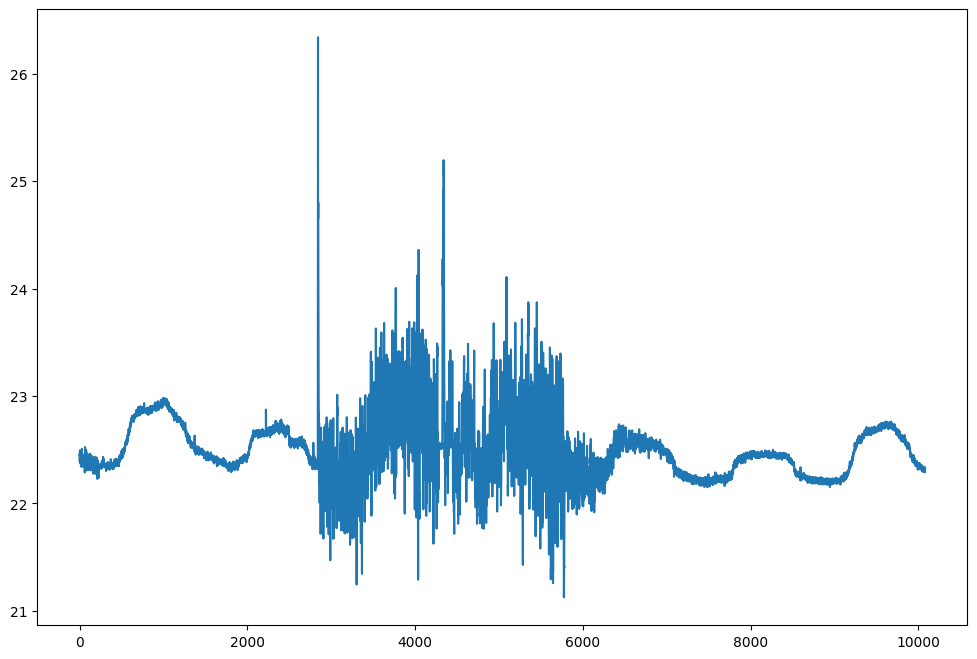

In [22]:
fig,axes = plt.subplots(1,1,figsize=(12,8))
axes.plot(np.arange(1,10081),pred_list,label='prediction')

In [23]:
len(pred_list)

10080

In [24]:
target = data.iloc[-split:]
target=list(target.values.reshape(-1,1))
score=SMAPE()(FloatTensor(list(np.array(pred_list).reshape(-1,1))),FloatTensor(target))*100
print('SMAPE',score.item(),'%')

SMAPE 0.4580842852592468 %


In [25]:
pred_list

[22.45479965209961,
 22.4614200592041,
 22.38805389404297,
 22.418743133544922,
 22.49420166015625,
 22.399322509765625,
 22.436391830444336,
 22.4633846282959,
 22.414600372314453,
 22.385692596435547,
 22.39946174621582,
 22.367572784423828,
 22.440689086914062,
 22.447856903076172,
 22.443248748779297,
 22.42684555053711,
 22.376773834228516,
 22.406776428222656,
 22.403564453125,
 22.409931182861328,
 22.46148681640625,
 22.34255027770996,
 22.3549861907959,
 22.421438217163086,
 22.393226623535156,
 22.452802658081055,
 22.452133178710938,
 22.507246017456055,
 22.422208786010742,
 22.342308044433594,
 22.3526554107666,
 22.40631675720215,
 22.376026153564453,
 22.447864532470703,
 22.443201065063477,
 22.44260597229004,
 22.395336151123047,
 22.371601104736328,
 22.4482479095459,
 22.442007064819336,
 22.386940002441406,
 22.378299713134766,
 22.399431228637695,
 22.354787826538086,
 22.39503288269043,
 22.41280746459961,
 22.45170021057129,
 22.433040618896484,
 22.3670825958251

In [26]:
len(target)

10080

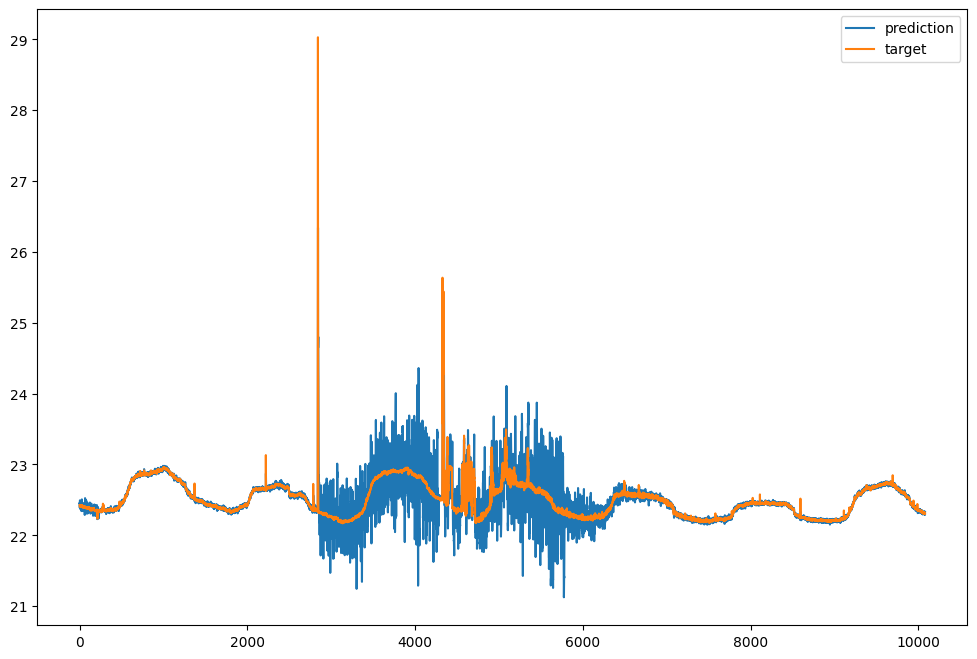

In [27]:
fig,axes = plt.subplots(1,1,figsize=(12,8))
axes.plot(np.arange(1,10081),pred_list[:],label='prediction')
axes.plot(np.arange(1,10081),target[:],label='target')
axes.legend()

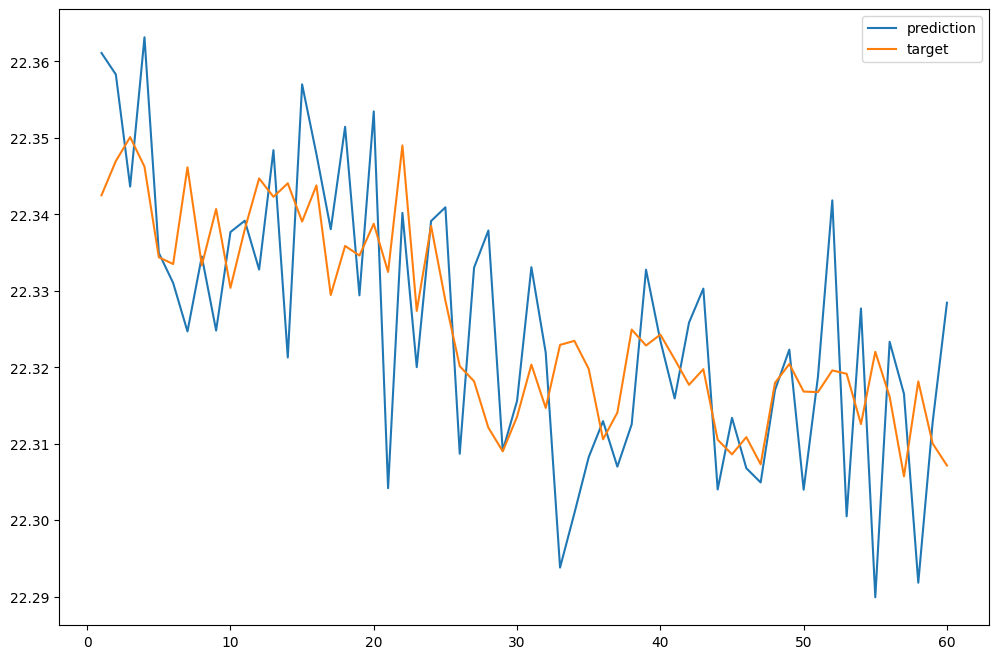

In [28]:
fig,axes = plt.subplots(1,1,figsize=(12,8))
axes.plot(np.arange(1,61),pred_list[-60:],label='prediction')
axes.plot(np.arange(1,61),target[-60:],label='target')
axes.legend()

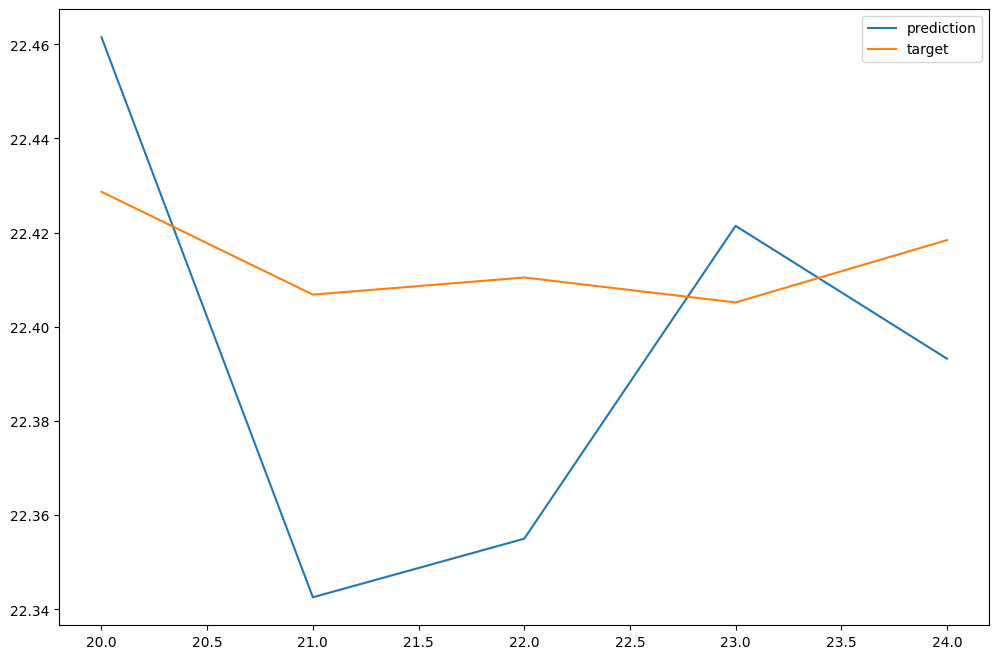

In [29]:
fig,axes = plt.subplots(1,1,figsize=(12,8))
axes.plot(np.arange(20,25),pred_list[20:25],label='prediction')
axes.plot(np.arange(20,25),target[20:25],label='target')
axes.legend()

In [30]:
np.mean(time_list)

0.7957015011282195

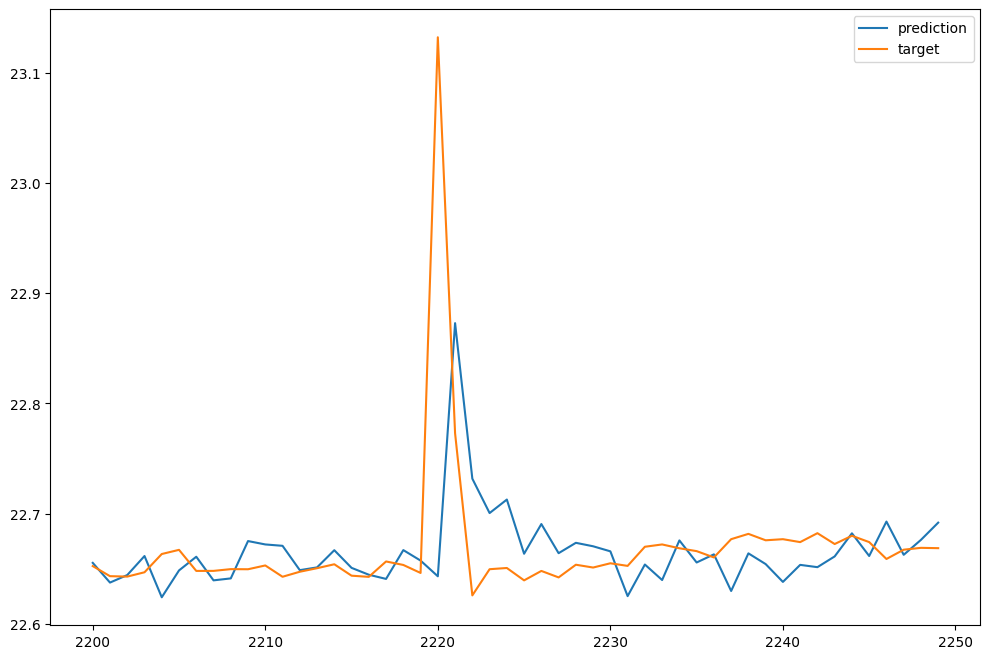

In [31]:
fig,axes = plt.subplots(1,1,figsize=(12,8))
axes.plot(np.arange(2200,2250),pred_list[2200:2250],label='prediction')
axes.plot(np.arange(2200,2250),target[2200:2250],label='target')
axes.legend()